In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Wed Nov 24 18:44:05 PST 2021


# Verify X-factor prevalence in v4.5.5

# Load and clean data

Don't add `x_factor_effect` to index columns this time since it doesn't exist in this run.

In [2]:
data = csr.VivariumResults.cleaned_from_model_spec('4.5.5', '2021_11_22_09_07_22')
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
#vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario']

# Create a dictionary to store figures to save later

In [4]:
figs = {}

In [5]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/

v2.1_gbd_2020_wasting	       v4.5.2_x_factor
v2.3_wasting_birth_prevalence  v4.5.3_x_factor_targeted_exposure
v2.4_corrected_fertility       v4.5.4_x_factor_wasting_propensity
v2.5_stunting


# Compute x-factor prevalence by age group and year

Looks like X-factor prevalence is close to 50%, which matches the model spec (see bottom of notebook).

In [6]:
data.person_time

,age,input_draw,mam_treatment,measure,sam_treatment,scenario,sex,sq_lns,x_factor,year,value
0,1-5_months,29,covered,person_time,covered,baseline,female,covered,cat1,2022,0.000000
1,1-5_months,29,covered,person_time,covered,baseline,female,covered,cat1,2023,0.000000
2,1-5_months,29,covered,person_time,covered,baseline,female,covered,cat1,2024,0.000000
3,1-5_months,29,covered,person_time,covered,baseline,female,covered,cat1,2025,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23036,late_neonatal,946,uncovered,person_time,uncovered,wasting_treatment,male,uncovered,cat2,2023,127.586585
23037,late_neonatal,946,uncovered,person_time,uncovered,wasting_treatment,male,uncovered,cat2,2024,79.118412
23038,late_neonatal,946,uncovered,person_time,uncovered,wasting_treatment,male,uncovered,cat2,2025,43.297741
23039,late_neonatal,946,uncovered,person_time,uncovered,wasting_treatment,male,uncovered,cat2,2026,27.290897


In [7]:
x_factor_prevalence = csr.get_prevalence(data, 'x_factor', ['age', 'year'], multiplier=100)
x_factor_prevalence

,age,year,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,1-5_months,2022,29,baseline,cat1,50.032903,state_person_time,state_person_time,100,prevalence
1,1-5_months,2022,29,baseline,cat2,49.967097,state_person_time,state_person_time,100,prevalence
2,1-5_months,2022,29,wasting_treatment,cat1,50.032903,state_person_time,state_person_time,100,prevalence
3,1-5_months,2022,29,wasting_treatment,cat2,49.967097,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
1436,late_neonatal,2026,946,baseline,cat1,50.313552,state_person_time,state_person_time,100,prevalence
1437,late_neonatal,2026,946,baseline,cat2,49.686448,state_person_time,state_person_time,100,prevalence
1438,late_neonatal,2026,946,wasting_treatment,cat1,50.313552,state_person_time,state_person_time,100,prevalence
1439,late_neonatal,2026,946,wasting_treatment,cat2,49.686448,state_person_time,state_person_time,100,prevalence


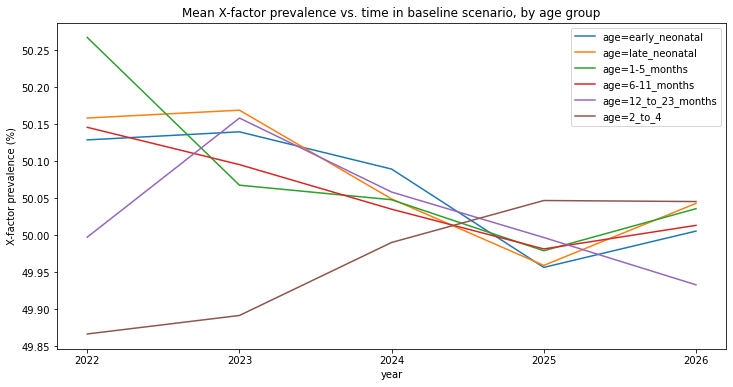

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
# x_factor_effect=1.1
title = "Mean X-factor prevalence vs. time in baseline scenario, by age group"
csp.plot_over_time_by_column(
    x_factor_prevalence.query(f"scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'X-factor prevalence (%)',
    title,
    False
)
# figs['x_factor_prevalence_by_age_group_in_baseline'] = fig
figs[title] = fig

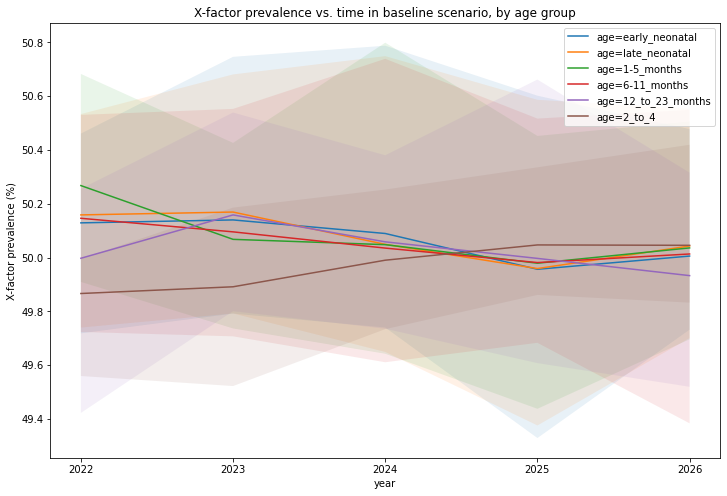

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
title = "X-factor prevalence vs. time in baseline scenario, by age group"
csp.plot_over_time_by_column(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'X-factor prevalence (%)',
    title,
    True
)
figs[title] = fig

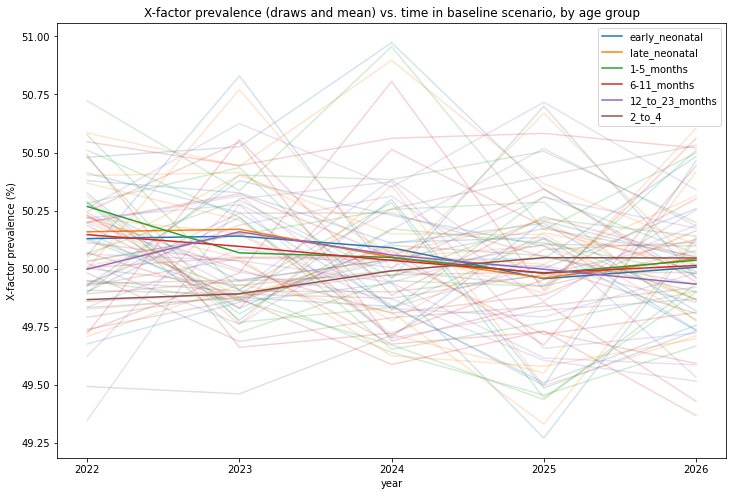

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
title = "X-factor prevalence (draws and mean) vs. time in baseline scenario, by age group"
csp.plot_draws_over_time_by_age(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'X-factor prevalence (%)',
    title,
)
# figs['x_factor_prevalence_draws_by_age_group_in_baseline'] = fig
figs[title] = fig

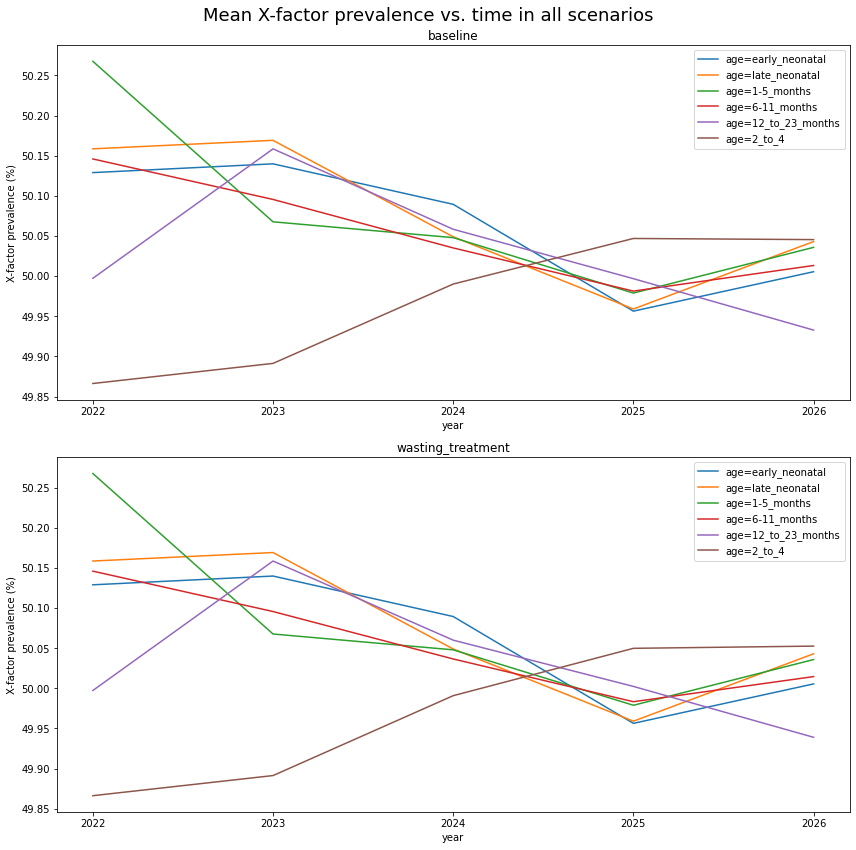

In [11]:
# x_factor_effect=1.5
title = "Mean X-factor prevalence vs. time in all scenarios"
fig = csp.plot_over_time_by_column_for_each_scenario(
    x_factor_prevalence.query(f"x_factor=='cat1'"),
    'age',
    ylabel='X-factor prevalence (%)',
    suptitle=title,
    uncertainty=False,
)
# figs['x_factor_prevalence_by_age_group_in_all_scenarios'] = fig
figs[title] = fig

# Compute X-factor prevalence stratified by year, age, wasting state

In [12]:
# This computes P(X-factor | year, age, wasting_state)
x_factor_prevalence_by_wasting_state = csr.get_prevalence(
    data, 'x_factor', strata=['year', 'age', 'wasting_state'], multiplier=100
)
x_factor_prevalence_by_wasting_state

,year,age,wasting_state,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,mild_child_wasting,29,baseline,cat1,100.000000,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,mild_child_wasting,29,baseline,cat2,0.000000,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,mild_child_wasting,29,wasting_treatment,cat1,100.000000,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,mild_child_wasting,29,wasting_treatment,cat2,0.000000,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
5756,2026,late_neonatal,susceptible_to_child_wasting,946,baseline,cat1,26.655376,state_person_time,state_person_time,100,prevalence
5757,2026,late_neonatal,susceptible_to_child_wasting,946,baseline,cat2,73.344624,state_person_time,state_person_time,100,prevalence
5758,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat1,26.655376,state_person_time,state_person_time,100,prevalence
5759,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat2,73.344624,state_person_time,state_person_time,100,prevalence


# Plot X-factor prevalence in each wasting state for each age group

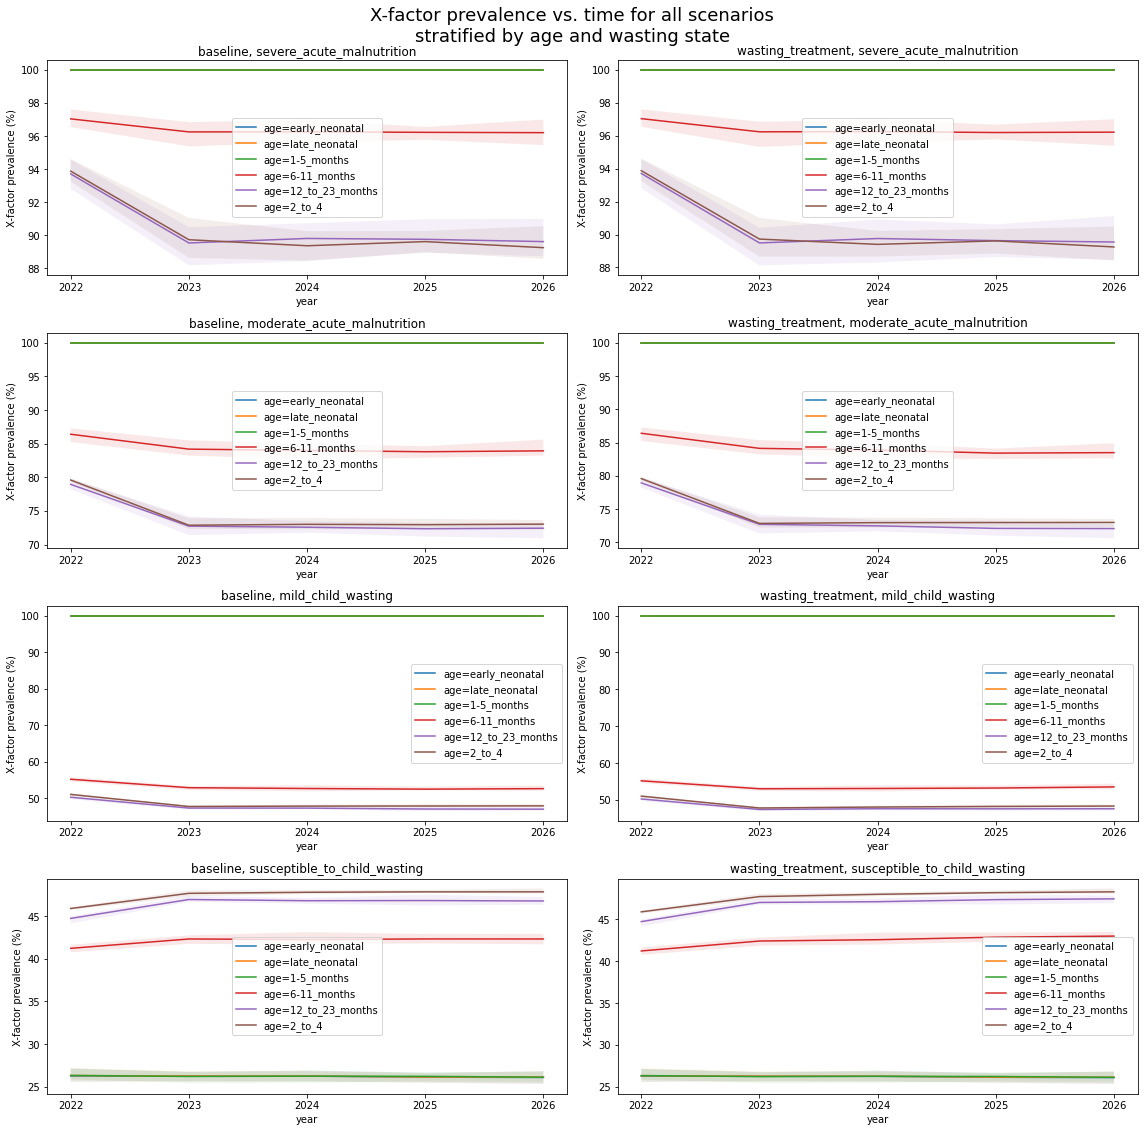

In [13]:
title = "X-factor prevalence vs. time for all scenarios\nstratified by age and wasting state"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_prevalence_by_wasting_state.query("x_factor=='cat1'"),
    colname='age',
    ylabel='X-factor prevalence (%)',
    suptitle=title
)
figs[title] = fig

# Compute the "reference" joint prevalence of X-factor and wasting state from the wasting state prevalence, based on the X-factor exposure initialization parameters from v4.5.3

X-factor exposure by wasting state, from v4.5.3: sam=0.6, mam=0.5, mild=0.25, tmrel=0.01

We'll look at these to compare with Model 4.5.3.

In [14]:
wasting_state_prevalence = csr.get_prevalence(
    data, 'wasting_state', ['year', 'age'], multiplier=100,
)
wasting_state_prevalence

,year,age,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,mild_child_wasting,20.708816,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,moderate_acute_malnutrition,8.756674,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,severe_acute_malnutrition,2.863253,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,susceptible_to_child_wasting,67.671258,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2876,2026,late_neonatal,946,wasting_treatment,mild_child_wasting,20.369060,state_person_time,state_person_time,100,prevalence
2877,2026,late_neonatal,946,wasting_treatment,moderate_acute_malnutrition,8.692821,state_person_time,state_person_time,100,prevalence
2878,2026,late_neonatal,946,wasting_treatment,severe_acute_malnutrition,3.194303,state_person_time,state_person_time,100,prevalence
2879,2026,late_neonatal,946,wasting_treatment,susceptible_to_child_wasting,67.743817,state_person_time,state_person_time,100,prevalence


In [15]:
wasting_state_prevalence.wasting_state.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting'],
      dtype=object)

In [16]:
# These match the values in model_specification.yaml from v4.5.3
x_factor_initial_exposures = {
    'severe_acute_malnutrition': 0.6,
    'moderate_acute_malnutrition': 0.5,
    'mild_child_wasting': 0.25,
    'susceptible_to_child_wasting': 0.01,
}

# This computes the "reference" joint prevalence of X factor and wasting state, stratified by
# year and age, i.e. the conditional probability reference_prevalence(X-factor, wasting_state | year, age),
# where the reference_prevalence measure is determined by the above fractions of each wasting state.
# See the analogous computation for the simulation results below.
x_factor_wasting_state_reference_exposure = wasting_state_prevalence.assign(
    value=lambda df: df['value'] * df['wasting_state'].map(x_factor_initial_exposures)
)
x_factor_wasting_state_reference_exposure

,year,age,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,mild_child_wasting,5.177204,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,moderate_acute_malnutrition,4.378337,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,severe_acute_malnutrition,1.717952,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,susceptible_to_child_wasting,0.676713,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2876,2026,late_neonatal,946,wasting_treatment,mild_child_wasting,5.092265,state_person_time,state_person_time,100,prevalence
2877,2026,late_neonatal,946,wasting_treatment,moderate_acute_malnutrition,4.346410,state_person_time,state_person_time,100,prevalence
2878,2026,late_neonatal,946,wasting_treatment,severe_acute_malnutrition,1.916582,state_person_time,state_person_time,100,prevalence
2879,2026,late_neonatal,946,wasting_treatment,susceptible_to_child_wasting,0.677438,state_person_time,state_person_time,100,prevalence


In [17]:
x_factor_reference_exposure = vp.marginalize(x_factor_wasting_state_reference_exposure, 'wasting_state')
x_factor_reference_exposure

,age,denominator_measure,input_draw,measure,multiplier,numerator_measure,scenario,year,value
0,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2022,11.950205
1,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2023,12.041271
2,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2024,12.026695
3,1-5_months,state_person_time,29,prevalence,100,state_person_time,baseline,2025,11.949132
...,...,...,...,...,...,...,...,...,...
716,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2023,12.295171
717,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2024,12.202389
718,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2025,12.099384
719,late_neonatal,state_person_time,946,prevalence,100,state_person_time,wasting_treatment,2026,12.032695


# Plot "reference" overall X-factor exposure in each age group based on the X-factor exposure initialization parameters

We can compare these plots to the plots from Model 4.5.3 to see how the "target" joint prevalence has changed.

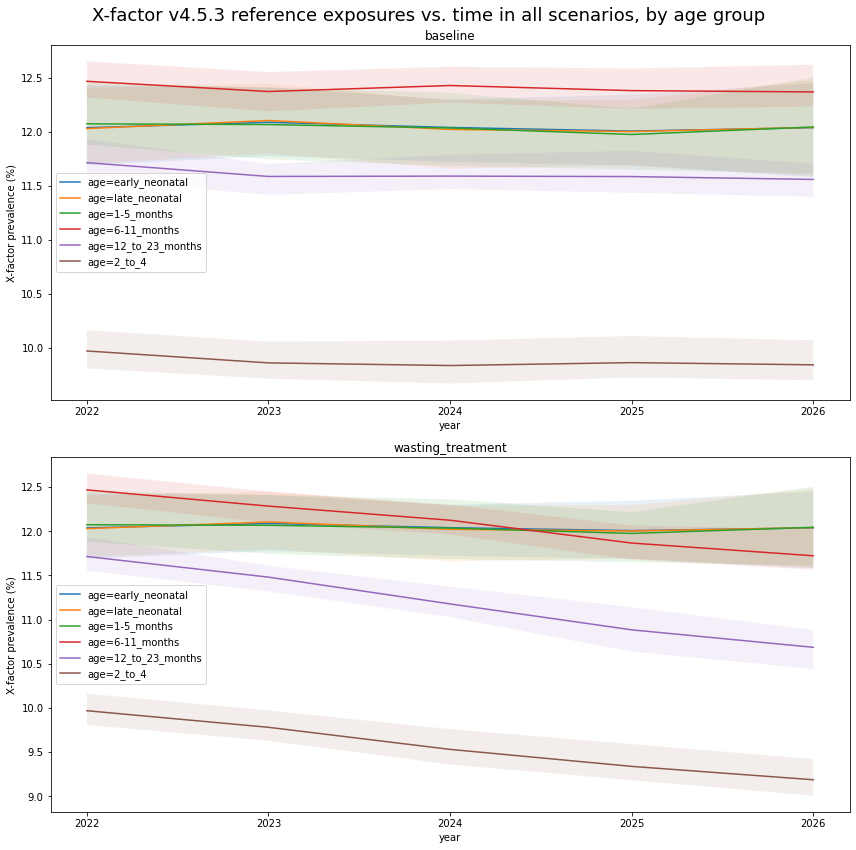

In [18]:
# fig, ax = plt.subplots(figsize=(12,6))
title = "X-factor v4.5.3 reference exposures vs. time in all scenarios, by age group"
fig = csp.plot_over_time_by_column_for_each_scenario(
    x_factor_reference_exposure,
    'age',
    'X-factor prevalence (%)',
    title,
    True
);
figs[title] = fig

# Plot "reference" joint prevalence of X-factor and wasing state, stratified by year and age (based on X-factor exposure parametrs from v4.5.3)

We can compare these plots to the plots from Model 4.5.3 to see how the "target" joint prevalence has changed.

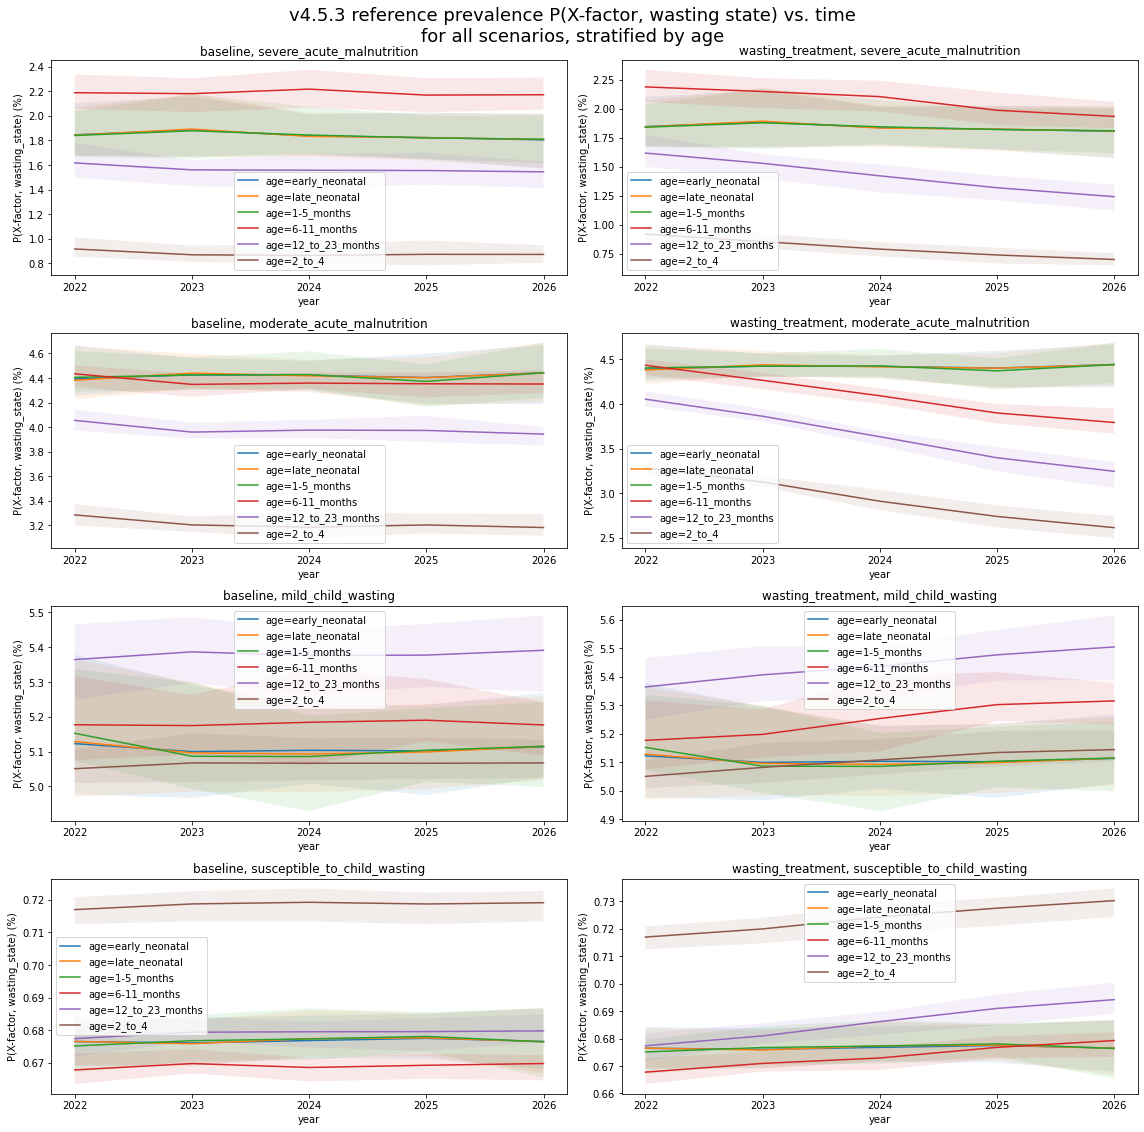

In [19]:
title = "v4.5.3 reference prevalence P(X-factor, wasting state) vs. time\nfor all scenarios, stratified by age"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_wasting_state_reference_exposure,
    'age',
    'P(X-factor, wasting_state) (%)',
    title,
    True
)
figs[title] = fig

# Compute joint (X-factor, wasting_state) prevalence stratified by year and age group, and plot it

This is a different view of the conditional X-factor prevalence plotted previously, which may provide additional insights. We can also compare these plots to the plots from Models 4.5.3 and 4.5.4 to see how the joint prevalence has changed.

**Plan for future code update** to `get_prevalence`: It would be more intuitive to be able to compute a joint prevalence like this by passing `['x_factor', 'wasting_state']` to `state_variable`, rather than having to pass one of the variables to `state_variable` and the other(s) to `numerator_broadcast`.

In [20]:
# This computes P(X-factor, wasting_state | year, age),
# i.e. P(X-factor | wasting_state, year, age) * P(wasting_state | year, age)
x_factor_wasting_state_prevalence = csr.get_prevalence(
    data, 'x_factor', strata=['year', 'age'], numerator_broadcast='wasting_state', multiplier=100
)
x_factor_wasting_state_prevalence

,year,age,input_draw,scenario,x_factor,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,cat1,mild_child_wasting,20.708816,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,29,baseline,cat1,moderate_acute_malnutrition,8.756674,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,29,baseline,cat1,severe_acute_malnutrition,2.863253,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,29,baseline,cat1,susceptible_to_child_wasting,17.704161,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
5756,2026,late_neonatal,946,wasting_treatment,cat2,mild_child_wasting,0.000000,state_person_time,state_person_time,100,prevalence
5757,2026,late_neonatal,946,wasting_treatment,cat2,moderate_acute_malnutrition,0.000000,state_person_time,state_person_time,100,prevalence
5758,2026,late_neonatal,946,wasting_treatment,cat2,severe_acute_malnutrition,0.000000,state_person_time,state_person_time,100,prevalence
5759,2026,late_neonatal,946,wasting_treatment,cat2,susceptible_to_child_wasting,49.686448,state_person_time,state_person_time,100,prevalence


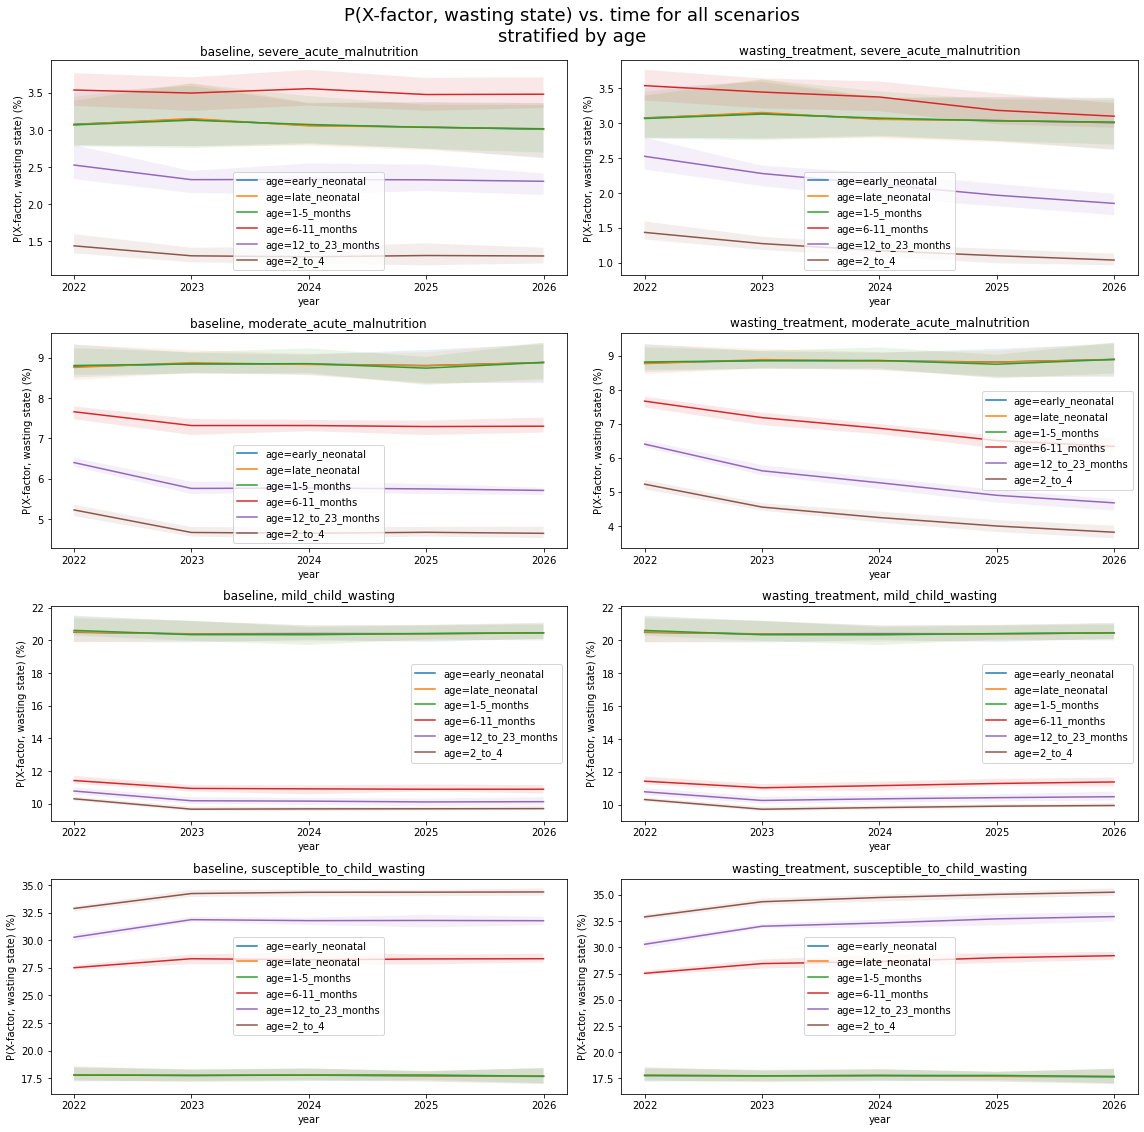

In [21]:
title = "P(X-factor, wasting state) vs. time for all scenarios\nstratified by age"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_wasting_state_prevalence.query("x_factor=='cat1'"),
    colname='age',
    ylabel='P(X-factor, wasting state) (%)',
    suptitle=title
)
figs[title] = fig

# Plot wasting state prevalence vs. time

The joint (X-factor, wasting state) prevalence plotted above equals the wasting state prevalence plotted below times the wasting-state-conditional X-factor prevalence plotted previously.

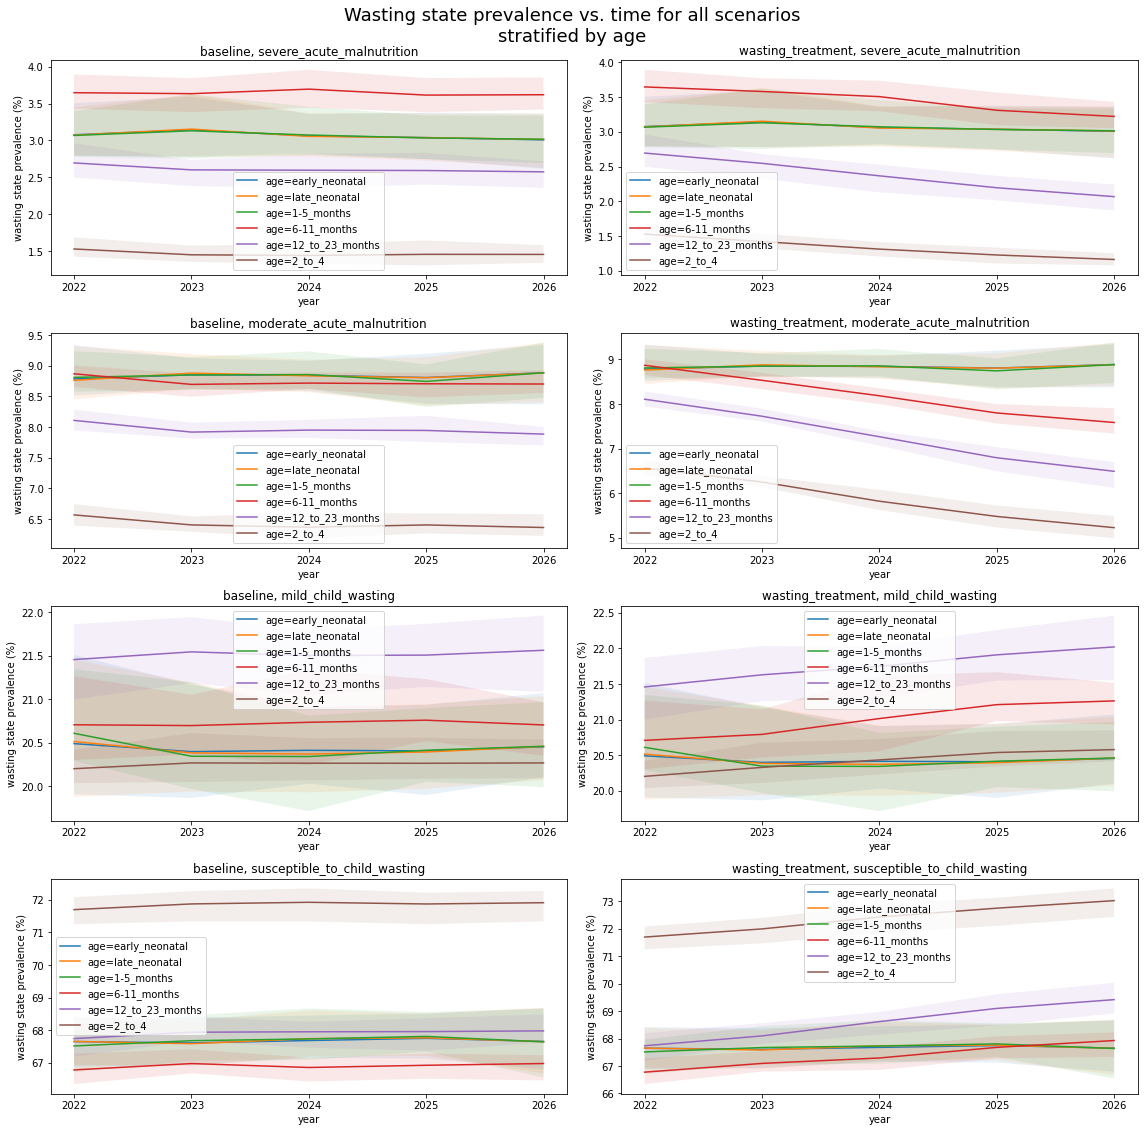

In [22]:
title = "Wasting state prevalence vs. time for all scenarios\nstratified by age"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    wasting_state_prevalence,
    colname='age',
    ylabel='wasting state prevalence (%)',
    suptitle=title
)
figs[title] = fig

# Define directories for saving figures

In [23]:
# project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v4.5.5_linear_scale-up_etc'
model_timestamp = '2021_11_22_09_07_22'
username = 'ndbs'

In [24]:
# model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

In [25]:
# We'll use this function to format the figures' title strings into legitimate file names for saving.
def convert_to_variable_name(string):
    """Converts a string to a valid Python variable.
    Runs of non-word characters (regex matchs \W+) are converted to '_', and '_' is appended to the
    beginning of the string if the string starts with a digit (regex matches ^(?=\d)).
    Solution copied from here:
    https://stackoverflow.com/questions/3303312/how-do-i-convert-a-string-to-a-valid-variable-name-in-python
    """
    return re.sub('\W+|^(?=\d)', '_', string)
convert_to_variable_name(title)

'Wasting_state_prevalence_vs_time_for_all_scenarios_stratified_by_age'

# Save figures to my home directory and J drive

In [26]:
# We'll use figure titles as filenames, but we'll remove non-word characters first
list(figs.keys())

['Mean X-factor prevalence vs. time in baseline scenario, by age group',
 'X-factor prevalence vs. time in baseline scenario, by age group',
 'X-factor prevalence (draws and mean) vs. time in baseline scenario, by age group',
 'Mean X-factor prevalence vs. time in all scenarios',
 'X-factor prevalence vs. time for all scenarios\nstratified by age and wasting state',
 'X-factor v4.5.3 reference exposures vs. time in all scenarios, by age group',
 'v4.5.3 reference prevalence P(X-factor, wasting state) vs. time\nfor all scenarios, stratified by age',
 'P(X-factor, wasting state) vs. time for all scenarios\nstratified by age',
 'Wasting state prevalence vs. time for all scenarios\nstratified by age']

In [27]:
for figure_name, fig in figs.items():
    for directory in [output_dir, j_output_dir]: 
        fig.savefig(f"{directory}/{convert_to_variable_name(figure_name)}.pdf")

In [28]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v4.5.5_linear_scale-up_etc/

Mean_X_factor_prevalence_vs_time_in_all_scenarios.pdf
Mean_X_factor_prevalence_vs_time_in_baseline_scenario_by_age_group.pdf
P_X_factor_wasting_state_vs_time_for_all_scenarios_stratified_by_age.pdf
v4_5_3_reference_prevalence_P_X_factor_wasting_state_vs_time_for_all_scenarios_stratified_by_age.pdf
Wasting_state_prevalence_vs_time_for_all_scenarios_stratified_by_age.pdf
X_factor_prevalence_draws_and_mean_vs_time_in_baseline_scenario_by_age_group.pdf
X_factor_prevalence_vs_time_for_all_scenarios_stratified_by_age_and_wasting_state.pdf
X_factor_prevalence_vs_time_in_baseline_scenario_by_age_group.pdf
X_factor_v4_5_3_reference_exposures_vs_time_in_all_scenarios_by_age_group.pdf


# Load model spec yaml file to see what's in it

To see the contents you can do

```Python
print(yaml.dump(model_spec))
```

after loading the `model_specification.yaml` file into a dictionary called `model_spec`.

With the output stream parameter of `yaml.dump()` set to `None` (default) and with `default_flow_style=False` (which is the [default if the yaml data has nested collections](https://pyyaml.org/wiki/PyYAMLDocumentation#FrequentlyAskedQuestions)), calling `yaml.dump()` on the loaded dictionary returns a string that is the same as the contents of the original `.yaml` file as returned by `file.read()`.

In [29]:
count_data_path = csr.get_count_data_path('4.5.5', '2021_11_22_09_07_22')
count_data_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_22_09_07_22/count_data/'

In [30]:
output_path = count_data_path[:-len('count_data/')]
output_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_22_09_07_22/'

In [31]:
!ls /ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_22_09_07_22/

branches.yaml  logs			 __pycache__
count_data     model_specification.yaml  requirements.txt
keyspace.yaml  output.hdf		 settings.py


In [32]:
model_spec_path = f"{output_path}/model_specification.yaml"
with open(model_spec_path, 'r') as model_spec_file:
    model_spec = yaml.safe_load(model_spec_file) # Load contents into a nested dictionary
type(model_spec)

dict

In [33]:
# We can use yaml.dump() to produce a nicely formatted string.
# Writing this string to file would produce a valid .yaml file.
print(yaml.dump(model_spec))

components:
  vivarium_ciff_sam:
    components:
    - ChildWasting()
    - LowBirthWeight()
    - ShortGestation()
    - XFactorExposure()
    - WastingTreatment('severe_acute_malnutrition_treatment')
    - WastingTreatment('moderate_acute_malnutrition_treatment')
    - SQLNSTreatment()
    - WastingTreatmentIntervention('severe_acute_malnutrition_treatment')
    - WastingTreatmentIntervention('moderate_acute_malnutrition_treatment')
    - SQLNSIntervention()
    - DisabilityObserver('wasting')
    - MortalityObserver('wasting')
    - DiseaseObserver('diarrheal_diseases', 'wasting')
    - DiseaseObserver('measles', 'wasting')
    - DiseaseObserver('lower_respiratory_infections', 'wasting')
    - DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')
    - CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')
  vivarium_public_health:
    disease:
    - SIS('diarrheal_diseases')
    - SIS_fixed_duration('measles', '10.0')
    - SIS('lower_respirator

In [34]:
# Read entire file into a string to compare with yaml.dump()
# They're identical
with open(model_spec_path, 'r') as model_spec_file:
    model_spec_contents = model_spec_file.read()

model_spec_contents == yaml.dump(model_spec)

True

# See what the X-factor exposure configuration looks like in this model

In [35]:
model_spec['configuration'].keys()

dict_keys(['child_wasting', 'effect_of_x_factor_on_mild_child_wasting', 'effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition', 'effect_of_x_factor_on_moderate_acute_malnutrition_to_severe_acute_malnutrition', 'input_data', 'interpolation', 'intervention', 'metrics', 'population', 'randomness', 'time', 'x_factor'])

In [36]:
model_spec['configuration']['x_factor']

{'exposure': 0.5}